In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
import json
from wordcloud import WordCloud
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
warnings.filterwarnings(action='ignore')
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances, cosine_distances
from fuzzywuzzy import fuzz


nlp = spacy.load('en')
nltk.download('wordnet')
stops = set(stopwords.words("english"))
pal = sns.color_palette()

pd.set_option('display.max_colwidth', 100)

[nltk_data] Downloading package wordnet to /Users/andrada/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Overview 

In [7]:
df_decatt = pd.read_table('misclassified1/misclassified.quora.dec_att.training_1k.tsv', sep='\t', encoding='utf-8',
                     names=['question1', 'question2', 'truth', 'prediction'])

df_decatt = df_decatt[['truth', 'question1', 'question2', 'prediction']]
df_decatt.head()

,truth,question1,question2,prediction
0,0,b'do women support each other more than men do',b'do women need more than men',1
1,0,b'what are the most likely for the us state',b'if the us ever which states are the most likely to become independent',1
2,1,"b""what software does use in it 's computer""",b'what kind of software do and disney use to',0
3,1,b'what do you guys know about',b'what do you know think about',0
4,0,b'how do i increase capacity',b'how can i increase my without',1


In [8]:
df_esim = pd.read_table('misclassified1/misclassified.quora.esim.training_1k.tsv', sep='\t', encoding='utf-8',
                     names=['question1', 'question2', 'truth', 'prediction'])

df_esim = df_esim[['truth', 'question1', 'question2', 'prediction']]
df_esim.head()

,truth,question1,question2,prediction
0,0,b'do women support each other more than men do',b'do women need more than men',1
1,1,b'how can one root android devices',b'how do i root an android device',0
2,1,b'can we donate blood after getting a',b'can i donate blood if i have a',0
3,1,b'now donald trump is the president of us what is the impact on india',b'what will be the impact of trump presidency on india',0
4,1,b'what are the best was to lose weight',b'how should i lose weight',0


In [2]:
df_test = pd.read_table('Quora_question_pair_partition/test.tsv', sep='\t', encoding='utf-8',
                     names=['is_duplicate','question1', 'question2', 'id'])

In [17]:
df_train = pd.read_table('Quora_question_pair_partition/train.tsv', sep='\t', encoding='utf-8',
                     names=['is_duplicate','question1', 'question2', 'id'])

In [9]:
df_bimpm_all = pd.read_json('predictions/result_bimpm.json', encoding='utf-8', orient='records')
df_bimpm_all = df_bimpm_all.T
df_bimpm_all = df_bimpm_all[['truth', 'sent1', 'sent2', 'prediction', 'probs']]
df_bimpm_all = df_bimpm_all.rename(columns={'sent1' : 'question1', 
                         'sent2':'question2'})
df_bimpm = df_bimpm_all.loc[df_bimpm_all['truth'] != df_bimpm_all['prediction']]
df_bimpm[['truth','prediction']] = df_bimpm[['truth','prediction']].apply(pd.to_numeric)

In [45]:
def get_counts(data):
    test_qs = pd.Series(data['question1'].tolist() + data['question2'].tolist()).astype(str)

    qmarks = np.mean(test_qs.apply(lambda x: '?' in x))
    fullstop = np.mean(test_qs.apply(lambda x: '.' in x))
    equals = np.mean(test_qs.apply(lambda x: '=' in x))
    capital_first = np.mean(test_qs.apply(lambda x: x[0].isupper()))
    capitals = np.mean(test_qs.apply(lambda x: max([y.isupper() for y in x])))
    numbers = np.mean(test_qs.apply(lambda x: max([y.isdigit() for y in x])))
    avgchar = np.mean(test_qs.apply(len))
    avgword = np.mean(test_qs.apply(lambda x: len(x.split(' '))))
    stopw = np.mean(test_qs.apply(lambda x: len([x for x in x.split() if x in stops])))

    print("Pairs of questions: {}".format(data[data.columns[0]].count()))
    print("Number of duplicates {}%".format(round(data[data.columns[0]].mean()*100, 2)))
    print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
    print('Questions with equals: {:.2f}%'.format(equals * 100))
    print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
    print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
    print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
    print('Questions with numbers: {:.2f}%'.format(numbers * 100))
    print('Average number of characters: {:.2f}'.format(avgchar))
    print('Average number of words: {:.2f}'.format(avgword))
    print('Average number of stopword: {:.2f} \n'.format(stopw))

# get_counts(df_decatt)
# get_counts(df_esim)
# get_counts(df_bimpm)
# get_counts(df_test)
get_counts(df_train)

Pairs of questions: 384346
Number of duplicates 36.24%
Questions with question marks: 99.87%
Questions with equals: 0.18%
Questions with full stops: 6.39%
Questions with capitalised first letters: 97.82%
Questions with capital letters: 99.95%
Questions with numbers: 11.84%
Average number of characters: 62.03
Average number of words: 12.69
Average number of stopword: 4.22 



In [27]:
df_train.isnull().sum()
df_train.dropna(inplace=True)

In [83]:
qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
dist_qs = qs.apply(lambda x: len(x.split(' ')))

In [85]:
np.mean(dist_qs)

12.68993823273821

In [94]:
dist_qs[dist_qs <= 40].count()

764142

In [80]:
df_train['question1'].apply(lambda x: x.split()).head()

0                            [What, is, your, review, of, Hidden, Figures, -LRB-, 2016, movie, -RRB-, ?]
1    [Currently, ,, all, Supreme, Court, Justices, come, from, very, elite, law, schools, ,, is, it, ...
2                                           [Why, is, saltwater, taffy, candy, imported, in, Austria, ?]
3                                  [Who, has, the, better, stable, of, characters, ,, DC, or, Marvel, ?]
4    [What, is, difference, between, CAT, and, GMAT, in, terms, of, syllabus, ,, admission, ,, diffic...
Name: question1, dtype: object

In [77]:
df_train['question2'].apply(lambda x: [x for x in x.split() if x not in stops]).iloc[210:220]

210                                        [Why, people, Donald, Trump, running, president, ?]
211                                            [Why, microwaved, food, get, colder, faster, ?]
212                                                              [How, movies, make, money, ?]
213         [What, small, restaurant, chains, Washington, d.c, ?, -LRB-, 10, locations, -RRB-]
214                                                  [What, best, way, go, getting, mentor, ?]
215                                              [How, I, prove, Schrödinger, 's, equation, ?]
216    [I, bad, teeth, bad, habits, early, 20s, Its, effecting, confidence, able, smile, I, ?]
217         [What, feel, like, man, ejaculate, inside, anus, -LRB-, without, condom, -RRB-, ?]
218                                       [How, I, trace, location, mobile, call, received, ?]
219                                                   [Am, I, mentally, ill, I, depression, ?]
Name: question2, dtype: object

In [164]:
df_decatt.groupby('truth').count()

,question1,question2,prediction
truth,,,
0,2253,2253,2253
1,1001,1001,1001


In [165]:
df_esim.groupby('truth').count()

,question1,question2,prediction
truth,,,
0,799,799,799
1,3589,3589,3589


In [166]:
df_bimpm.groupby('truth').count()

,question1,question2,prediction,probs
truth,,,,
0,616,616,616,616
1,613,613,613,613


# Preprocessing

In [3]:
def prepare_datasets(data):
    data['question1'] = data['question1'].str.lower()
    data['question2'] = data['question2'].str.lower()

    data['question1'] = data['question1'].str.replace('[^\w\s]','')
    data['question2'] = data['question2'].str.replace('[^\w\s]','')

    data['question1'] = data['question1'].str.replace('"','')
    data['question2'] = data['question2'].str.replace('"','')

    data['question1'] = data['question1'].str.replace('\'','')
    data['question2'] = data['question2'].str.replace('\'','')

    data['question1'] = data['question1'].str.strip()
    data['question2'] = data['question2'].str.strip()

# prepare_datasets(df_train)
prepare_datasets(df_test)

In [168]:
# df_train.dropna(inplace=True)
# df_train.isnull().sum()

In [169]:
def prepare_error_datasets(df):
    df['question1'] = df['question1'].map(lambda x: x.lstrip('b'))
    df['question2'] = df['question2'].map(lambda x: x.lstrip('b'))

    df['question1'] = df['question1'].str.replace('[^\w\s]','')
    df['question2'] = df['question2'].str.replace('[^\w\s]','')

    df['question1'] = df['question1'].str.replace('"','')
    df['question2'] = df['question2'].str.replace('"','')

    df['question1'] = df['question1'].str.replace('\'','')
    df['question2'] = df['question2'].str.replace('\'','')

    df['question1'] = df['question1'].str.strip()
    df['question2'] = df['question2'].str.strip()
    
prepare_error_datasets(df_decatt)    
prepare_error_datasets(df_esim)  
prepare_error_datasets(df_bimpm)

# Error Analysis

In [170]:
def percent_of_total_error(x):
    if x['#test_data'] != 0:
        return round(x['#error_data']*100/x['#test_data'], 2)
    else:
        return 0

def percent_of_total_test(x):
    return round(x['#test_data']*100/10000, 2)

def accuracy_improvement(x):
    return round(x['#error_data']*100/10000, 2)

In [171]:
def contains_tag(tags, data, category):
    df_stats = pd.DataFrame(columns=['category','tag', 'data'])
    total1 = 0
    for tag in tags:
        count1 = data[data.columns[0]].loc[data['question1'].str.contains(tag + " ")].count()
        count2 = data[data.columns[0]].loc[data['question2'].str.contains(tag + " ")].count()   
        total = count1 + count2
        
        df_stats = df_stats.append({'category':category,
                                    'tag': tag,
                                    'data': total}, ignore_index=True)      
    return df_stats

In [172]:
def prepare_stats(df, df_test, contains_function, tags, category):
    df_stats_test = contains_function(tags, df_test, category)
    df_stats_error = contains_function(tags, df, category)
    
    df_stats_test.rename(columns={'data':'#test_data'}, inplace=True)
    df_stats_error.rename(columns={'data':'#error_data'}, inplace=True)
    df_stats = df_stats_test.merge(df_stats_error, how='inner', on=['tag', 'category'])
    return df_stats

In [41]:
def count_tag(tags, data, category):
    df_stats = pd.DataFrame(columns=['category','tag', 'data'])
    count = data[data.columns[0]].loc[data['contains_antonym'] == 1].count()
    df_stats = df_stats.append({'category':category,
                                'tag': category,
                                'data': count}, ignore_index=True)      
    return df_stats

def lemmatize(row):
    lemmatizer = WordNetLemmatizer()
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(row)]

def check_antonyms(row):
    word_synonyms = []
    for word in row['q1_lemmatized']:
        for synset in wordnet.synsets(word):
            for lemma in synset.lemmas():
                if lemma.antonyms():
                    if lemma.antonyms()[0].name() in row['q2_lemmatized']:
                        word_synonyms.append([word,lemma.antonyms()[0].name()])
    return word_synonyms

def antonym_flag(df):
    df['q1_lemmatized'] = df['question1'].apply(lemmatize)
    df['q2_lemmatized'] = df['question2'].apply(lemmatize)
    df['antonyms'] = df.apply(check_antonyms, axis=1, raw=True)
    df['contains_antonym'] = 0
    df['contains_antonym'].loc[df['antonyms'].str.len() != 0] = 1
    df.drop(columns=['q1_lemmatized', 'q2_lemmatized', 'antonyms'], inplace=True)
    return df

df_decatt = antonym_flag(df_decatt)
df_esim = antonym_flag(df_esim)
df_bimpm = antonym_flag(df_bimpm)
df_test = antonym_flag(df_test)

In [42]:
def contains_ner(tags, data, category):
    df_stats = pd.DataFrame(columns=['category','tag', 'data'])
    total1 = 0
    for tag in tags:
        count1 = data[data.columns[0]].loc[data['q1_ner'].str.contains(tag)].count()
        count2 = data[data.columns[0]].loc[data['q2_ner'].str.contains(tag)].count()   
        total = count1 + count2
        
        df_stats = df_stats.append({'category':category,
                                    'tag': tag,
                                    'data': total}, ignore_index=True)      
    return df_stats

In [ ]:
def get_ner_list(row):
    doc = nlp(row)
    ner = []
    for ent in doc.ents:
        ner.append(ent.label_)
    ner = ' '.join(ner)
    return ner

def create_ner_column(data):
    data['q1_ner'] = data['question1'].apply(get_ner_list)
    data['q2_ner'] = data['question2'].apply(get_ner_list)

create_ner_column(df_decatt)
create_ner_column(df_esim)
create_ner_column(df_bimpm)
create_ner_column(df_test)
# create_ner_column(df_train)

In [173]:
wh_words = ['what', 'when', 'where', 'why', 'who', 'which', 'whom', 'how']
conditional = ['if']
quantifiers = ['much', 'enough', 'more', 'most', 'less', 'least', 'none', 'some', 
               'any', 'many', 'few', 'several', 'almost', 'nearly']
belief = ['know', 'believe', 'understand', 'doubt', 'think', 'suppose',
          'recognize', 'forget', 'remember', 'imagine', 'mean', 'agree', 
          'disagree', 'deny', 'promise']
modals = ['can', 'could', 'may', 'might', 'must', 'will', 'would', 'should']
negation = ['no', 'not', 'neither', 'nor', 'never', 'none', 'nobody', 'nothing', 'nowhere', 'nobody']
discourse = ['so', 'and', 'but', 'anyway', 'firstly', 'lastly', 'although', 'however']
ner = ['GPE', 'NORP', 'PERSON', 'ORG', 'EVENT', 'LANGUAGE', 
       'PRODUCT', 'DATE', 'CARDINAL', 'TIME', 'QUANTITY', 'ORDINAL', 
       'WORK_OF_ART', 'LOC']
specific = ['difference', 'best', 'people', 'india', '\'s', '\'ve', '\'t', '\'d']

In [174]:
def create_stats_dataframe(df, df_test):
    df_stats_wh = prepare_stats(df, df_test, contains_tag, wh_words, "wh")
    df_stats_cond = prepare_stats(df, df_test, contains_tag, conditional, 'conditional')
    df_stats_quant = prepare_stats(df, df_test, contains_tag, quantifiers, 'quantifier')
    df_stats_belief = prepare_stats(df, df_test, contains_tag, belief, 'belief')
    df_stats_modals = prepare_stats(df, df_test, contains_tag, modals, 'modal')
    df_stats_negation = prepare_stats(df, df_test, contains_tag, negation, 'negation')
    df_stats_discourse = prepare_stats(df, df_test, contains_tag, discourse, 'discourse')
    df_stats_specific = prepare_stats(df, df_test, contains_tag, specific, 'specific')
#     df_stats_antonyms = prepare_stats(df, df_test, count_tag, [], "antonym")
#     df_stats_ner = prepare_stats(df, df_test, contains_ner, ner, "ner")
    df_stats = pd.concat([df_stats_wh, df_stats_cond, df_stats_quant, 
                          df_stats_belief, df_stats_modals, df_stats_negation,
                          df_stats_discourse, 
                          df_stats_specific])
    
    df_stats['%oftotal_test'] = df_stats.apply(percent_of_total_test, axis=1)   
    df_stats['%oftotal_error'] = df_stats.apply(percent_of_total_error, axis=1)
    df_stats['%acc_improv'] = df_stats.apply(accuracy_improvement, axis=1)
    return df_stats

In [175]:
df_stats = create_stats_dataframe(df_decatt, df_test)

In [176]:
df_stats.sort_values(by='%acc_improv',ascending=False).head()

,category,tag,#test_data,#error_data,%oftotal_test,%oftotal_error,%acc_improv
0,wh,what,7896,2653,78.96,33.60,26.53
7,wh,how,5447,1684,54.47,30.92,16.84
1,discourse,and,3004,866,30.04,28.83,8.66
0,modal,can,2864,807,28.64,28.18,8.07
3,wh,why,1845,662,18.45,35.88,6.62


In [177]:
df_stats.groupby('category')['%acc_improv'].sum().sort_values(ascending=False)

category
wh             58.41
modal          14.74
quantifier     10.69
discourse      10.26
specific       10.11
conditional     3.21
belief          3.21
negation        1.84
Name: %acc_improv, dtype: float64

In [178]:
df_stats

,category,tag,#test_data,#error_data,%oftotal_test,%oftotal_error,%acc_improv
0,wh,what,7896,2653,78.96,33.60,26.53
1,wh,when,596,186,5.96,31.21,1.86
2,wh,where,412,129,4.12,31.31,1.29
3,wh,why,1845,662,18.45,35.88,6.62
4,wh,who,595,177,5.95,29.75,1.77
5,wh,which,1060,343,10.60,32.36,3.43
6,wh,whom,16,7,0.16,43.75,0.07
7,wh,how,5447,1684,54.47,30.92,16.84
0,conditional,if,1027,321,10.27,31.26,3.21
0,quantifier,much,274,89,2.74,32.48,0.89


## DEC_ATT 
wh             25.12
modal           6.65
ner             5.98
discourse       4.16
quantifier      3.91
conditional     1.33
belief          1.18
negation        0.85
antonym         0.54

## ESIM
wh             25.49
modal           6.71
ner             5.89
discourse       4.52
quantifier      3.88
conditional     1.23
belief          1.13
negation        0.85
specific        0.66
antonym         0.52

## BIMPM
wh             21.57
ner             6.46
modal           5.79
discourse       3.58
quantifier      3.36
conditional     1.07
belief          0.99
negation        0.83
antonym         0.52

In [ ]:
df_stats.loc[df_stats['category'] == 'specific']

In [ ]:
# print(df[df.columns[0]].loc[df['question1'].str.contains('best') & df['question2'].str.contains('best')].count())
# print(df[df.columns[0]].loc[df['question1'].str.contains('best') & ~df['question2'].str.contains('best')].count())

# Exploratory Data Analysis

mean-test 57.68 std-test 30.81 mean-error 43.53 std-error 22.36 max-test 726.00 max-error 164.00
mean-test 57.68 std-test 30.81 mean-error 44.35 std-error 22.84 max-test 726.00 max-error 177.00
mean-test 57.68 std-test 30.81 mean-error 51.63 std-error 24.11 max-test 726.00 max-error 235.00


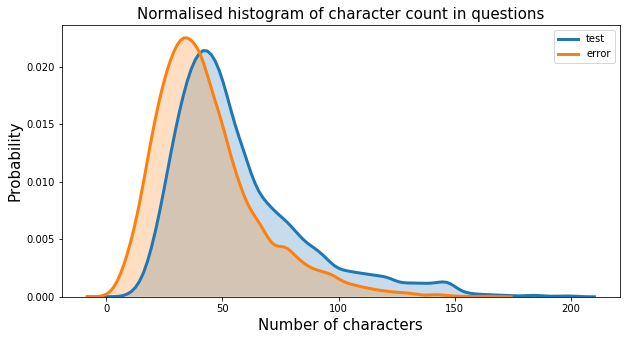

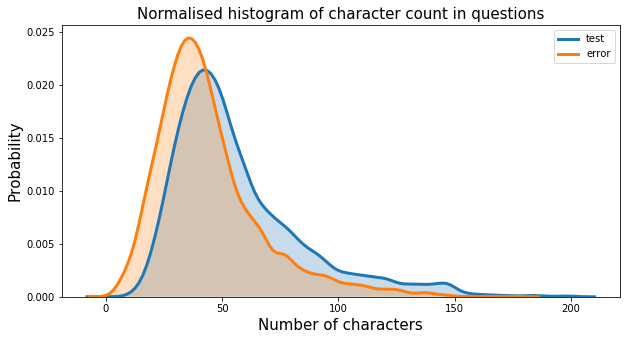

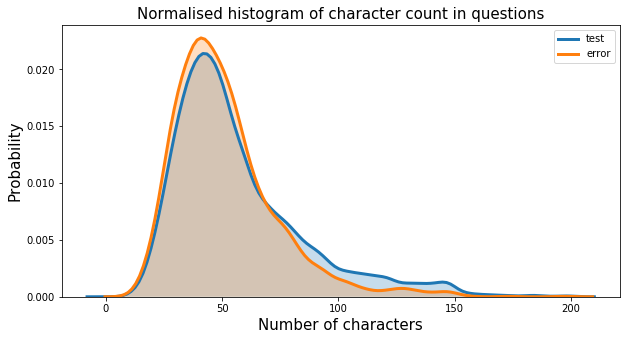

In [44]:
def character_count_hist(df, df_test):
    test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)
    error_qs = pd.Series(df['question1'].tolist() + df['question2'].tolist()).astype(str)

    dist_test = test_qs.apply(len)
    dist_error = error_qs.apply(len)
    filtered_test = dist_test[dist_test < 201]
    filtered_error = dist_error[dist_error < 201]
    plt.figure(figsize=(10, 5))
    sns.distplot(filtered_test, hist = False, kde = True, bins=200,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                 label = 'test')
    sns.distplot(filtered_error, hist = False, kde = True, bins=200,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                 label = 'error')
    plt.title('Normalised histogram of character count in questions', fontsize=15)
    plt.legend()
    plt.xlabel('Number of characters', fontsize=15)
    plt.ylabel('Probability', fontsize=15)

    print('mean-test {:.2f} std-test {:.2f} mean-error {:.2f} std-error {:.2f} max-test {:.2f} max-error {:.2f}'.format(dist_test.mean(), 
                              dist_test.std(), dist_error.mean(), dist_error.std(), dist_test.max(), dist_error.max()))

character_count_hist(df_decatt, df_test)
character_count_hist(df_esim, df_test)
character_count_hist(df_bimpm, df_test)

mean-test 11.34 std-test 6.30 mean-error 9.14 std-error 4.47 max-test 143.00 max-error 30.00
mean-test 11.34 std-test 6.30 mean-error 9.28 std-error 4.69 max-test 143.00 max-error 30.00
mean-test 11.34 std-test 6.30 mean-error 10.12 std-error 4.76 max-test 143.00 max-error 50.00


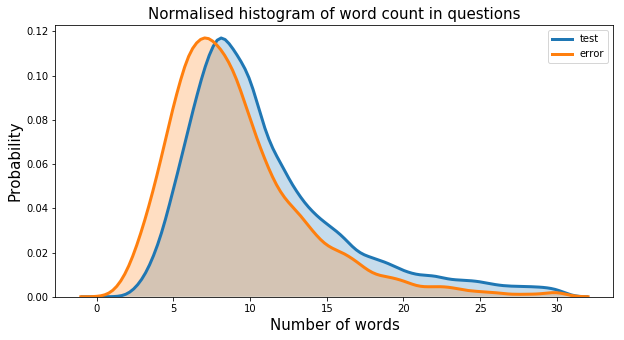

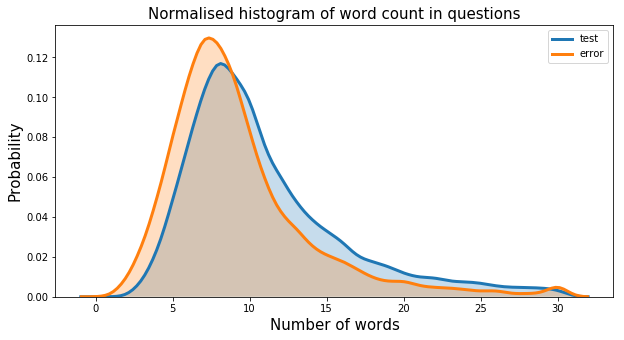

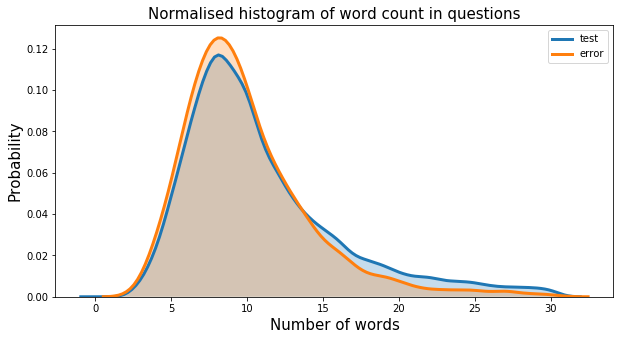

In [45]:
def word_count_hist(df, df_test):
    test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)
    error_qs = pd.Series(df['question1'].tolist() + df['question2'].tolist()).astype(str)
    
    dist_test = test_qs.apply(lambda x: len(x.split(' ')))
    dist_error = error_qs.apply(lambda x: len(x.split(' ')))

    plt.figure(figsize=(10, 5))
    filtered_test = dist_test[dist_test < 31]
    filtered_error = dist_error[dist_error < 31]
    sns.distplot(filtered_test, hist = False, kde = True, bins=50,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                 label = 'test')
    sns.distplot(filtered_error, hist = False, kde = True, bins=50,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                 label = 'error')
    plt.title('Normalised histogram of word count in questions', fontsize=15)
    plt.legend()
    plt.xlabel('Number of words', fontsize=15)
    plt.ylabel('Probability', fontsize=15)

    print('mean-test {:.2f} std-test {:.2f} mean-error {:.2f} std-error {:.2f} max-test {:.2f} max-error {:.2f}'.format(dist_test.mean(), 
                              dist_test.std(), dist_error.mean(), dist_error.std(), dist_test.max(), dist_error.max()))

word_count_hist(df_decatt, df_test)
word_count_hist(df_esim, df_test)
word_count_hist(df_bimpm, df_test)

mean-test 8.94 std-test 4.24 mean-error 9.39 std-error 4.73 max-test 30.00 max-error 30.00


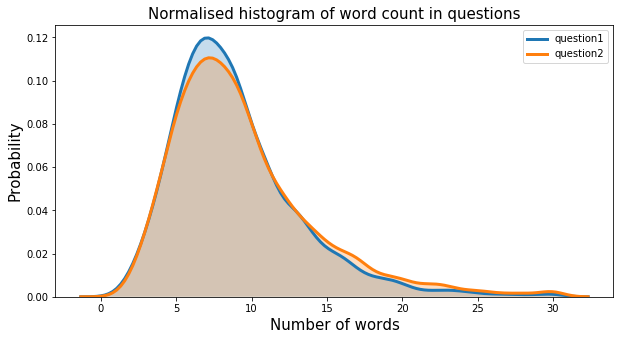

In [17]:
def word_count_hist(df):
    q1 = pd.Series(df['question1'].tolist()).astype(str)
    q2 = pd.Series(df['question2'].tolist()).astype(str)
    
    dist_q1 = q1.apply(lambda x: len(x.split(' ')))
    dist_q2 = q2.apply(lambda x: len(x.split(' ')))

    plt.figure(figsize=(10, 5))
    filtered_q1 = dist_q1[dist_q1 < 31]
    filtered_q2 = dist_q2[dist_q2 < 31]
    sns.distplot(filtered_q1, hist = False, kde = True, bins=50,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                 label = 'question1')
    sns.distplot(filtered_q2, hist = False, kde = True, bins=50,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                 label = 'question2')
    plt.title('Normalised histogram of word count in questions', fontsize=15)
    plt.legend()
    plt.xlabel('Number of words', fontsize=15)
    plt.ylabel('Probability', fontsize=15)

    print('mean-test {:.2f} std-test {:.2f} mean-error {:.2f} std-error {:.2f} max-test {:.2f} max-error {:.2f}'.format(dist_q1.mean(), 
                              dist_q1.std(), dist_q2.mean(), dist_q2.std(), dist_q1.max(), dist_q2.max()))

word_count_hist(df_decatt)

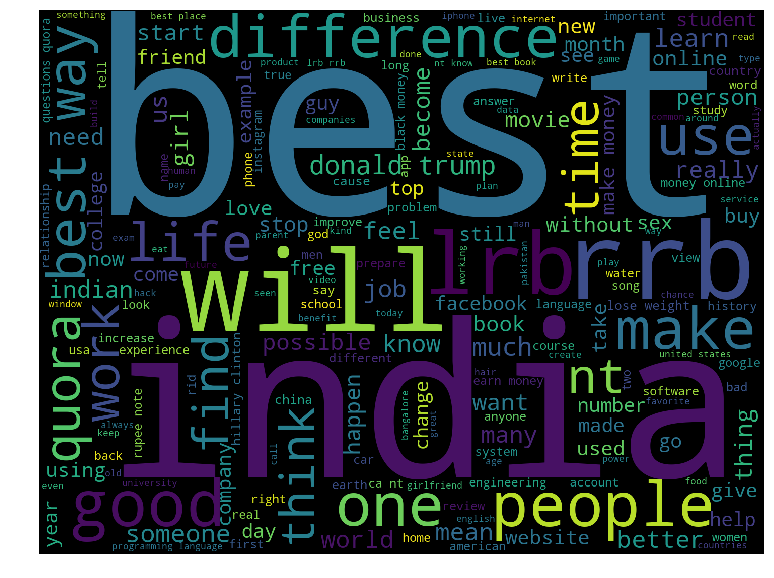

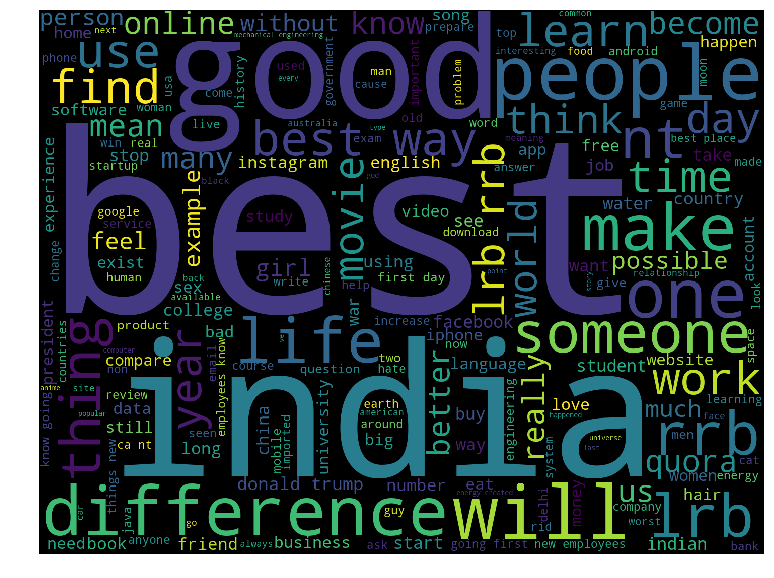

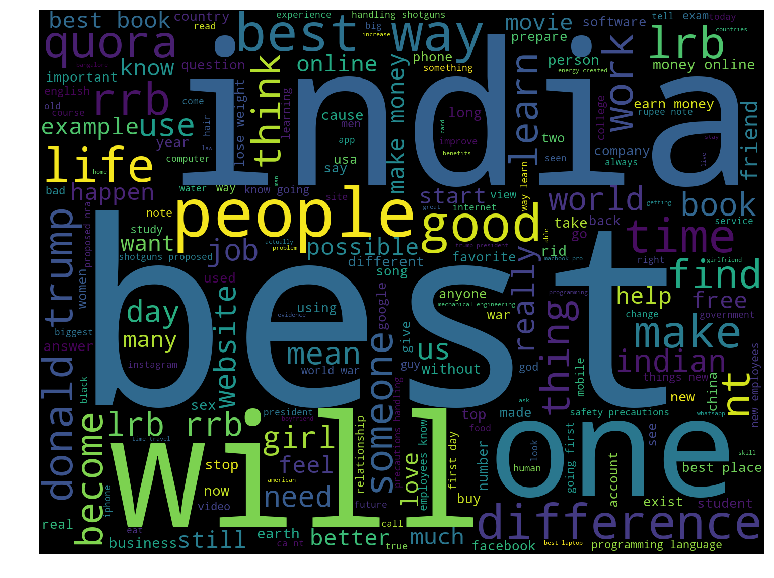

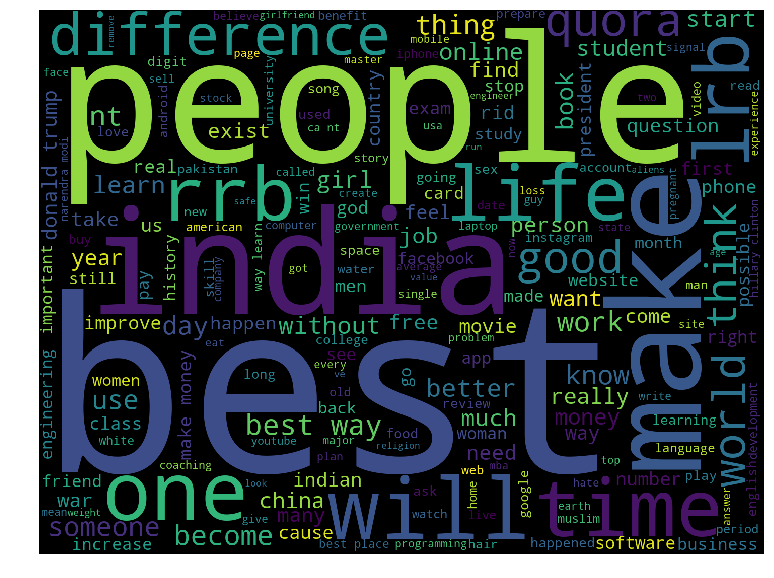

In [46]:
def word_cloud(df):
    test_qs = pd.Series(df['question1'].tolist() + df['question2'].tolist()).astype(str)
    
    cloud = WordCloud(width=1440, height=1080).generate(" ".join(test_qs.astype(str)))
    plt.figure(figsize=(15, 10))
    plt.imshow(cloud)
    plt.axis('off')

word_cloud(df_test)
word_cloud(df_decatt)
word_cloud(df_esim)
word_cloud(df_bimpm)

# Feature Engineering

In [11]:
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return round(R,2)

In [12]:
def get_qs(df):
    qs = pd.Series(df['question1'].tolist() + df['question2'].tolist()).astype(str)
    return qs
    
def tfidf_word_match_share(row, qs):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
    tfidf_matrix = tfidf_vectorizer.fit_transform(qs)
    feature_names = tfidf_vectorizer.get_feature_names()
    dense = tfidf_matrix.todense()
    word_index_dict = dict((j, i) for i,j in enumerate(feature_names))
    
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0    
    q1_tfidf = tfidf_vectorizer.transform([" ".join(q1words.keys())])
    q2_tfidf = tfidf_vectorizer.transform([" ".join(q2words.keys())])
    inter = np.intersect1d(q1_tfidf.indices, q2_tfidf.indices)
    shared_weights = 0
    for word_index in inter:
        shared_weights += (q1_tfidf[0, word_index] + q2_tfidf[0, word_index])
    total_weights = q1_tfidf.sum() + q2_tfidf.sum()
    return np.sum(shared_weights) / np.sum(total_weights)

In [13]:
def train_lda(df):
    qs = get_qs(df)
    seed = 1024
    lda = LatentDirichletAllocation(n_topics=20, doc_topic_prior=None, 
                                    topic_word_prior=None, learning_method='batch', 
                                    learning_decay=0.7, learning_offset=10.0, max_iter=10,
                                    batch_size=128, evaluate_every=-1, total_samples=1000000.0, 
                                    perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100,
                                    n_jobs=1, verbose=0, random_state=seed)
    bow = CountVectorizer(ngram_range=(1,1),max_df=0.95,min_df=3,stop_words='english')
    vect_orig = make_pipeline(bow,lda)
    vect_orig.fit(qs)
    return vect_orig

def compute_lda(row, vect_orig):
    q1_lda = vect_orig.transform([row['question1']])
    q2_lda = vect_orig.transform([row['question2']])
    return q1_lda, q2_lda

def euclidean_dist(row, vect_orig):
    q1_lda, q2_lda = compute_lda(row, vect_orig)
    sim = euclidean_distances(q1_lda, q2_lda)
    return round(sim[0][0],2)
    
def cosine_dist(row, vect_orig):
    q1_lda, q2_lda = compute_lda(row, vect_orig)
    sim = cosine_distances(q1_lda, q2_lda)
    return round(sim[0][0],2)

def manhattan_dist(row, vect_orig):
    q1_lda, q2_lda = compute_lda(row, vect_orig)
    sim = manhattan_distances(q1_lda, q2_lda)
    return round(sim[0][0],2)

def cosine_sim(row, vect_orig):
    q1_lda, q2_lda = compute_lda(row, vect_orig)
    sim = cosine_similarity(q1_lda, q2_lda)
    return round(sim[0][0],2)

In [14]:
def penn_to_wn(tag):
    """ Convert between a Penn Treebank tag to a simplified Wordnet tag """
    if tag.startswith('N'):
        return 'n'
 
    if tag.startswith('V'):
        return 'v'
 
    if tag.startswith('J'):
        return 'a'
 
    if tag.startswith('R'):
        return 'r'
 
    return None
 

def tagged_to_synset(word, tag):
    wn_tag = penn_to_wn(tag)
    if wn_tag is None:
        return None

    try:
        return wordnet.synsets(word, wn_tag)[0]
    except:
        return None
 
def sentence_similarity(sentence1, sentence2):
    """ compute the sentence similarity using Wordnet """
    # Tokenize and tag
    sentence1 = pos_tag(word_tokenize(sentence1))
    sentence2 = pos_tag(word_tokenize(sentence2))

    # Get the synsets for the tagged words
    synsets1 = [tagged_to_synset(*tagged_word) for tagged_word in sentence1]
    synsets2 = [tagged_to_synset(*tagged_word) for tagged_word in sentence2]

    # Filter out the Nones
    synsets1 = [ss for ss in synsets1 if ss]
    synsets2 = [ss for ss in synsets2 if ss]
    
    score, count = 0.0, 0

    # For each word in the first sentence
    for synset in synsets1:
        # Get the similarity value of the most similar word in the other sentence
        try:
            best_score = max([synset.path_similarity(ss) for ss in synsets2])
        except:
            best_score = None

        # Check that the similarity could have been computed
        if best_score is not None:
            score += best_score
            count += 1

    # Average the values
    if count != 0:
        return score / count
    else:
        return 0

def symmetric_sentence_similarity(row):
    """ compute the symmetric sentence similarity using Wordnet """
    return (sentence_similarity(row['question1'], row['question2']) + sentence_similarity(row['question2'], row['question1'])) / 2

In [34]:
def text_features(df):
    qs = get_qs(df)
    
    df['q1len'] = df['question1'].str.len()
    df['q2len'] = df['question2'].str.len()

    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    df['q1len'] = df['question1'].str.len()
    df['q2len'] = df['question2'].str.len()

    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
    
    df['word_overlap'] = df.apply( word_match_share, axis=1, raw=True)
#     df['tf_idf'] = df.apply( tfidf_word_match_share, qs=qs, axis=1)   
#     df['wn_sim'] = df.apply(symmetric_sentence_similarity, axis=1, raw=True)   
    
    vect_orig = train_lda(df)
    df['lda_cos_sim'] = df.apply(cosine_sim, vect_orig=vect_orig, axis=1)
#     df['lda_cos_dist'] = df.apply(cosine_dist, vect_orig=vect_orig, axis=1)
#     df['lda_manh_dist'] = df.apply(manhattan_dist, vect_orig=vect_orig, axis=1)
#     df['lda_eucl_dist'] = df.apply(euclidean_dist, vect_orig=vect_orig, axis=1)
    
    df['fuzz_qratio'] = df.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
    df['fuzz_WRatio'] = df.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)
    df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
#     df['fuzz_partial_token_set_ratio'] = df.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
    df['fuzz_partial_token_sort_ratio'] = df.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
    df['fuzz_token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
    df['fuzz_token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)

    df = df.fillna(0)


# text_features(df_decatt)
# text_features(df_esim)
# text_features(df_bimpm)
text_features(df_test)
text_features(df_train)

In [42]:
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, classification_report
from sklearn.grid_search import GridSearchCV

def results(model, X, y, prefix):
        model.fit(X,y)
        predicted = model.predict_proba(X)
        score = model.score(X, y)
        loss = log_loss(y, predicted)

        result = model.predict(X)
        accuracy = accuracy_score(y, result)
        
        print('{} score: {:.2f}, loss: {:.4f}, accuracy: {:.2f}'.format(
            prefix, score, loss, accuracy))
                    
        
        print("Confusion matrix:")
        print(confusion_matrix(y, result))

        print("Classification report:")
        target_names = ['non_duplicate', 'duplicate']
        print(classification_report(y, result, target_names=target_names))

X, y = df_train[df_train.columns.drop(['is_duplicate', 'question1', 'question2', 'id'])], df_train.is_duplicate
Xval, yval = df_test[df_test.columns.drop(['is_duplicate', 'question1', 'question2', 'id'])], df_test.is_duplicate

params = {
    "max_depth": [3, 4, 5, 6, 7],
    "n_estimators": [100, 200, 300, 400, 500],
    "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.3, 0.5]
}

xgb = XGBClassifier()
grid = GridSearchCV(xgb, param_grid=params, verbose=True, n_jobs=24)
grid.fit(X, y)
results(xgb, X, y, 'Training')
results(xgb, Xval, yval, 'Validation')

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:   48.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:  2.1min
[Parallel(n_jobs=24)]: Done 450 out of 450 | elapsed:  2.4min finished


Training score: 0.75, loss: 0.4607, accuracy: 0.75
Confusion matrix:
[[4743 1628]
 [ 891 2738]]
Classification report:
               precision    recall  f1-score   support

non_duplicate       0.84      0.74      0.79      6371
    duplicate       0.63      0.75      0.68      3629

  avg / total       0.76      0.75      0.75     10000

Validation score: 0.75, loss: 0.4825, accuracy: 0.75
Confusion matrix:
[[2958 2042]
 [ 434 4566]]
Classification report:
               precision    recall  f1-score   support

non_duplicate       0.87      0.59      0.70      5000
    duplicate       0.69      0.91      0.79      5000

  avg / total       0.78      0.75      0.75     10000



In [155]:
# df_test['fuzz_qratio'] = df_test['fuzz_qratio']*100 
# df_test['fuzz_WRatio'] = df_test['fuzz_WRatio']*100
# df_test['fuzz_partial_ratio'] = df_test['fuzz_partial_ratio']*100
# df_test['fuzz_partial_token_set_ratio'] = df_test['fuzz_partial_token_set_ratio']*100
# df_test['fuzz_partial_token_sort_ratio'] = df_test['fuzz_partial_token_sort_ratio']*100
# df_test['fuzz_token_set_ratio'] = df_test['fuzz_token_set_ratio']*100
# df_test['fuzz_token_sort_ratio'] = df_test['fuzz_token_sort_ratio']*100
df_test[['is_duplicate', 'question1', 'question2','lda_cos_sim', 'lda_cos_dist', 'lda_manh_dist', 'lda_eucl_dist']]

,is_duplicate,question1,question2,lda_cos_sim,lda_cos_dist,lda_manh_dist,lda_eucl_dist
0,1,what should i do to avoid sleeping in class,how do i not sleep in a boring class,0.07,0.93,1.50,0.79
1,0,do women support each other more than men do,do women need more compliments than men,0.90,0.10,0.50,0.35
2,1,how can one root android devices,how do i root an android device,0.04,0.96,1.50,1.06
3,0,how did hitler come to power,who followed hitler to power,0.63,0.37,0.64,0.41
4,1,can we donate blood after getting a tattoo,can i donate blood if i have a tattoo,0.98,0.02,0.24,0.13
5,0,what are reviews for the biovault 20 biometric gun safe,do you need a safe for a long gun in california,0.05,0.95,1.66,0.82
6,1,now donald trump is the president of us what is the impact on india,what will be the impact of trump presidency on india,0.52,0.48,1.05,0.72
7,0,who is owner of oyeshopcom,who is the owner of amulyamin,1.00,0.00,0.00,0.00
8,1,what are the best was to lose weight,how should i lose weight,1.00,0.00,0.16,0.08
9,0,why is a maaco paint job so cheap,what s the best way to preserve my car wash on my black car that has a new paint job,0.80,0.20,0.86,0.46


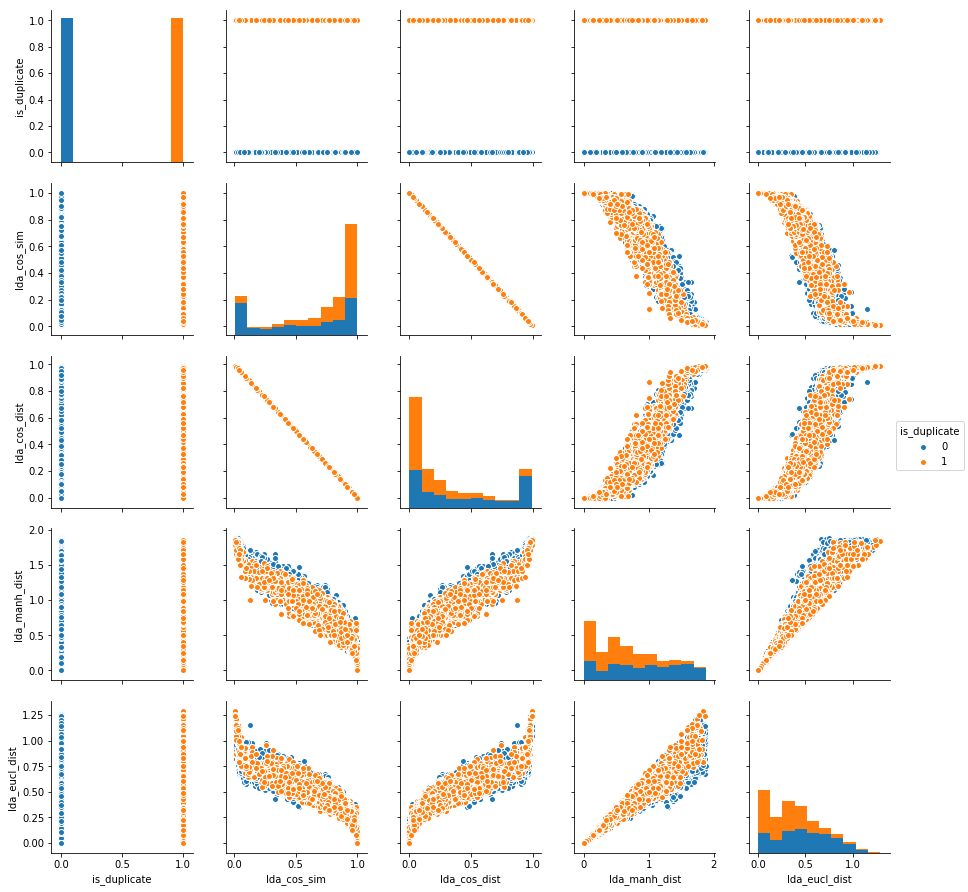

In [156]:
sns.pairplot(df_test[['is_duplicate', 'question1', 'question2','lda_cos_sim', 'lda_cos_dist', 'lda_manh_dist', 'lda_eucl_dist']], hue='is_duplicate')

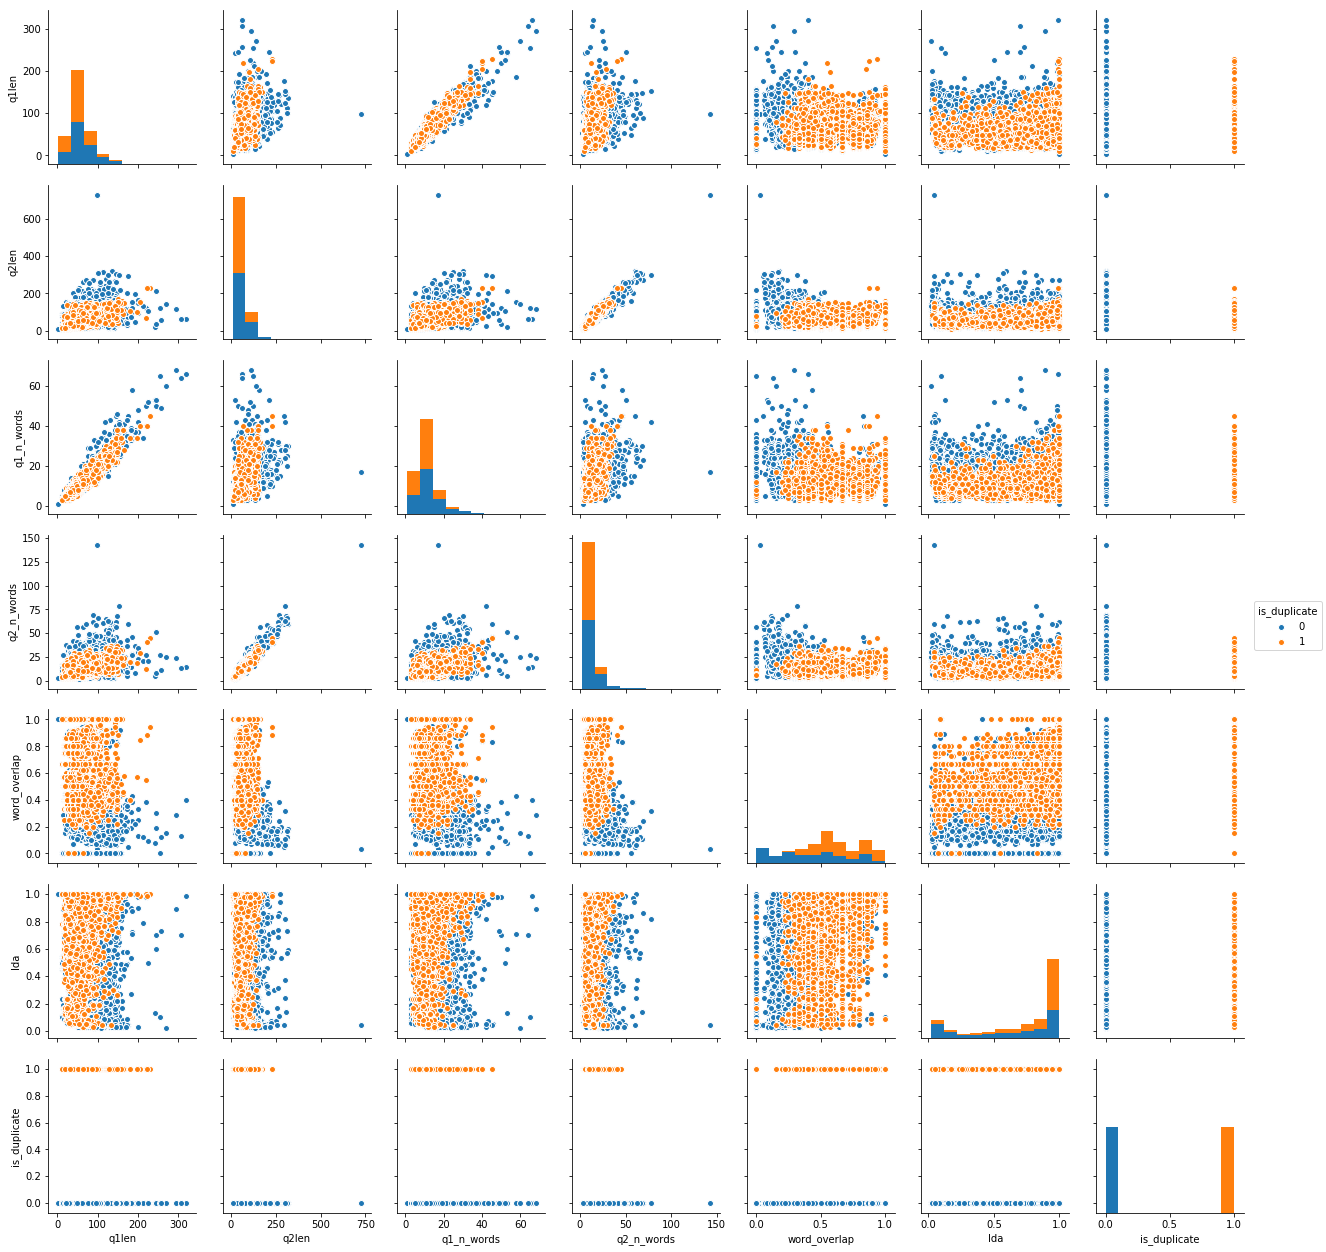

In [92]:
sns.pairplot(df_test[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_overlap','is_duplicate']], hue='is_duplicate')

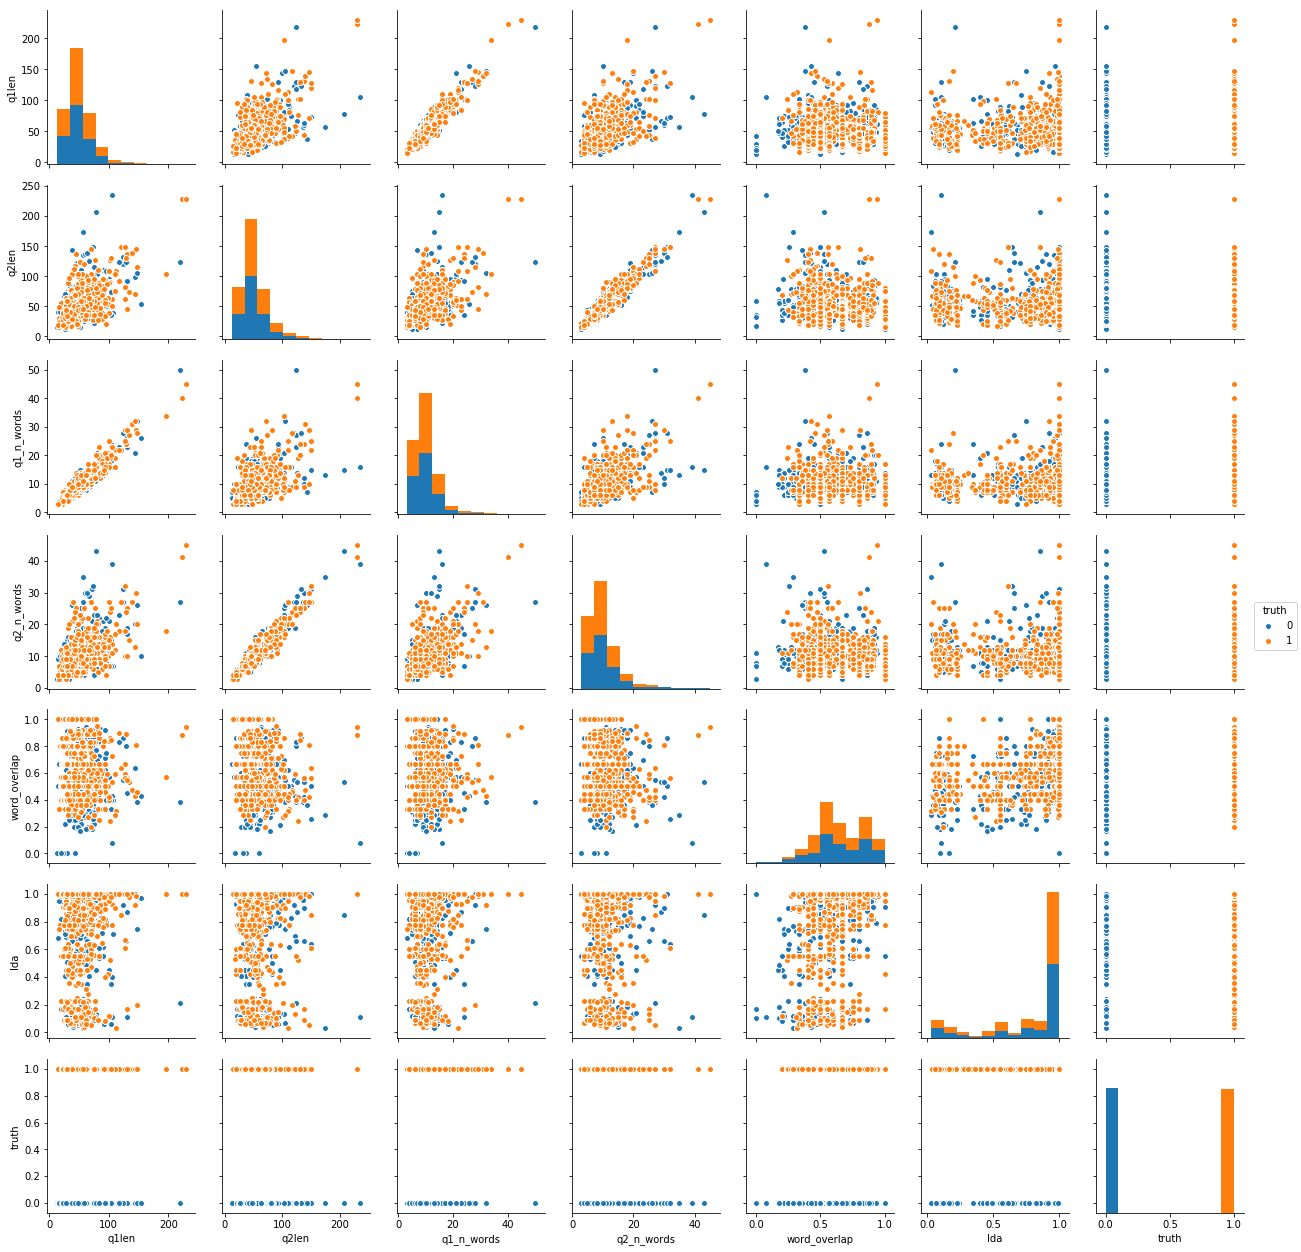

In [93]:
sns.pairplot(df_bimpm[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_overlap', 'lda','truth']], hue='truth')

## Word Overlap

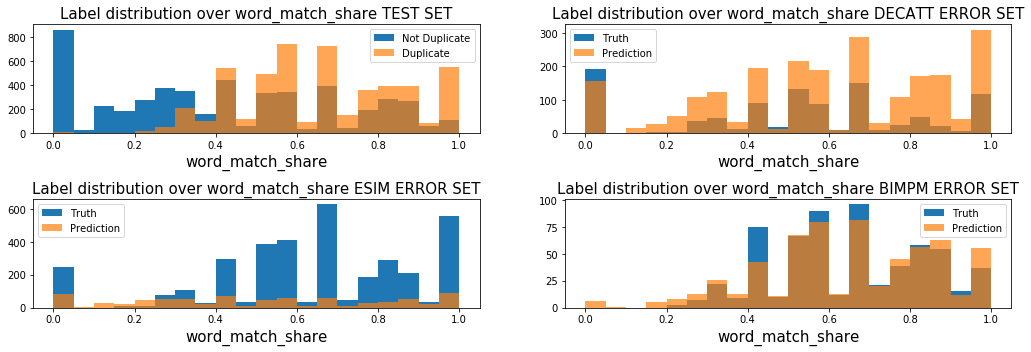

In [37]:
plt.figure(figsize=(15, 5))
plt.subplot(221)
plt.hist(df_test['word_overlap'].loc[df_test['is_duplicate'] == 0], range=[0,1], bins=20, label='Not Duplicate')
plt.hist(df_test['word_overlap'].loc[df_test['is_duplicate'] == 1], range=[0,1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share TEST SET', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

plt.subplot(222)
plt.hist(df_decatt['word_overlap'].loc[df_decatt['truth'] == 1], range=[0,1], bins=20, label='Truth')
plt.hist(df_decatt['word_overlap'].loc[df_decatt['prediction'] == 1], range=[0,1], bins=20, alpha=0.7, label='Prediction')
plt.legend()
plt.title('Label distribution over word_match_share DECATT ERROR SET', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

plt.subplot(223)
plt.hist(df_esim['word_overlap'].loc[df_esim['truth'] == 1], range=[0,1], bins=20, label='Truth')
plt.hist(df_esim['word_overlap'].loc[df_esim['prediction'] == 1], range=[0,1], bins=20, alpha=0.7, label='Prediction')
plt.legend()
plt.title('Label distribution over word_match_share ESIM ERROR SET', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

plt.subplot(224)
plt.hist(df_bimpm['word_overlap'].loc[df_bimpm['truth'] == 1], range=[0,1], bins=20, label='Truth')
plt.hist(df_bimpm['word_overlap'].loc[df_bimpm['prediction'] == 1], range=[0,1], bins=20, alpha=0.7, label='Prediction')
plt.legend()
plt.title('Label distribution over word_match_share BIMPM ERROR SET', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

plt.tight_layout()
plt.show()

## TF-IDF Score

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(221)
plt.hist(df_test['tf_idf'].loc[df_test['is_duplicate'] == 0], bins=20, range=[0,1], label='Not Duplicate')
plt.hist(df_test['tf_idf'].loc[df_test['is_duplicate'] == 1], bins=20, range=[0,1], alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share TEST SET', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

plt.subplot(222)
plt.hist(df_decatt['tf_idf'].loc[df_decatt['truth'] == 1], bins=20, range=[0,1], label='Truth')
plt.hist(df_decatt['tf_idf'].loc[df_decatt['prediction'] == 1], bins=20, range=[0,1], alpha=0.7, label='Prediction')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share DECATT ERROR SET', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

plt.subplot(223)
plt.hist(df_esim['tf_idf'].loc[df_esim['truth'] == 1], bins=20, range=[0,1], label='Truth')
plt.hist(df_esim['tf_idf'].loc[df_esim['prediction'] == 1], bins=20, range=[0,1], alpha=0.7, label='Prediction')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share ESIM ERROR SET', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

plt.subplot(224)
plt.hist(df_bimpm['tf_idf'].loc[df_bimpm['truth'] == 1], bins=20, range=[0,1], label='Truth')
plt.hist(df_bimpm['tf_idf'].loc[df_bimpm['prediction'] == 1], bins=20, range=[0,1], alpha=0.7, label='Prediction')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share BIMPM ERROR SET', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

plt.tight_layout()
plt.show()

## WordNet Similarity

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(221)
plt.hist(df_test['wn_sim'].loc[df_test['is_duplicate'] == 0], range=[0,1], bins=20, label='Not Duplicate')
plt.hist(df_test['wn_sim'].loc[df_test['is_duplicate'] == 1], range=[0,1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over wordnet_similarity TEST SET', fontsize=15)
plt.xlabel('wordnet_similarity', fontsize=15)

plt.subplot(222)
plt.hist(df_decatt['wn_sim'].loc[df_decatt['truth'] == 1], range=[0,1], bins=20, label='Truth')
plt.hist(df_decatt['wn_sim'].loc[df_decatt['prediction'] == 1], range=[0,1], bins=20, alpha=0.7, label='Prediction')
plt.legend()
plt.title('Label distribution over wordnet_similarity DECATT ERROR SET', fontsize=15)
plt.xlabel('wordnet_similarity', fontsize=15)

plt.subplot(223)
plt.hist(df_esim['wn_sim'].loc[df_esim['truth'] == 1], bins=20, range=[0,1], label='Truth')
plt.hist(df_esim['wn_sim'].loc[df_esim['prediction'] == 1], bins=20, range=[0,1], alpha=0.7, label='Prediction')
plt.legend()
plt.title('Label distribution over wordnet_similarity ESIM ERROR SET', fontsize=15)
plt.xlabel('wordnet_similarity', fontsize=15)

plt.subplot(224)
plt.hist(df_bimpm['wn_sim'].loc[df_bimpm['truth'] == 1], bins=20, range=[0,1], label='Truth')
plt.hist(df_bimpm['wn_sim'].loc[df_bimpm['prediction'] == 1], bins=20, range=[0,1], alpha=0.7, label='Prediction')
plt.legend()
plt.title('Label distribution over wordnet_similarity ESIM ERROR SET', fontsize=15)
plt.xlabel('wordnet_similarity', fontsize=15)

plt.tight_layout()
plt.show()

# LDA Similarity

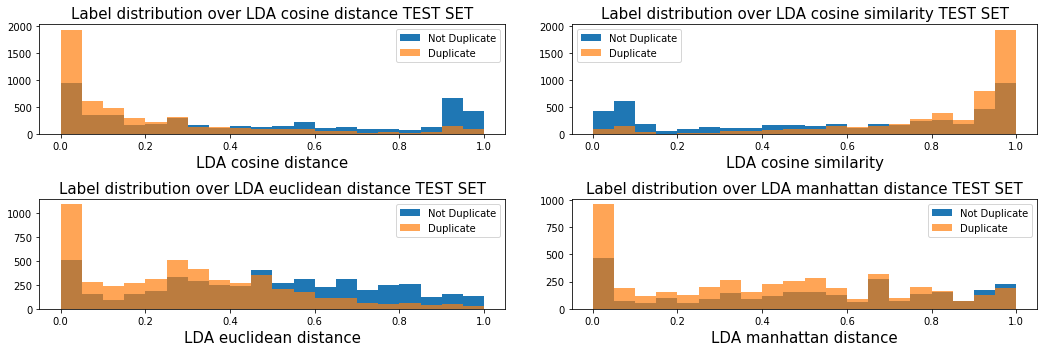

In [115]:
plt.figure(figsize=(15, 5))
plt.subplot(221)
plt.hist(df_test['lda_cos_dist'].loc[df_test['is_duplicate'] == 0], range=[0,1], bins=20, label='Not Duplicate')
plt.hist(df_test['lda_cos_dist'].loc[df_test['is_duplicate'] == 1], range=[0,1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over LDA cosine distance TEST SET', fontsize=15)
plt.xlabel('LDA cosine distance', fontsize=15)

plt.subplot(222)
plt.hist(df_test['lda_cos_sim'].loc[df_test['is_duplicate'] == 0], range=[0,1], bins=20, label='Not Duplicate')
plt.hist(df_test['lda_cos_sim'].loc[df_test['is_duplicate'] == 1], range=[0,1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over LDA cosine similarity TEST SET', fontsize=15)
plt.xlabel('LDA cosine similarity', fontsize=15)

plt.subplot(223)
plt.hist(df_test['lda_eucl_dist'].loc[df_test['is_duplicate'] == 0], range=[0,1], bins=20, label='Not Duplicate')
plt.hist(df_test['lda_eucl_dist'].loc[df_test['is_duplicate'] == 1], range=[0,1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over LDA euclidean distance TEST SET', fontsize=15)
plt.xlabel('LDA euclidean distance', fontsize=15)


plt.subplot(224)
plt.hist(df_test['lda_manh_dist'].loc[df_test['is_duplicate'] == 0], range=[0,1], bins=20, label='Not Duplicate')
plt.hist(df_test['lda_manh_dist'].loc[df_test['is_duplicate'] == 1], range=[0,1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over LDA manhattan distance TEST SET', fontsize=15)
plt.xlabel('LDA manhattan distance', fontsize=15)

plt.tight_layout()
plt.show()

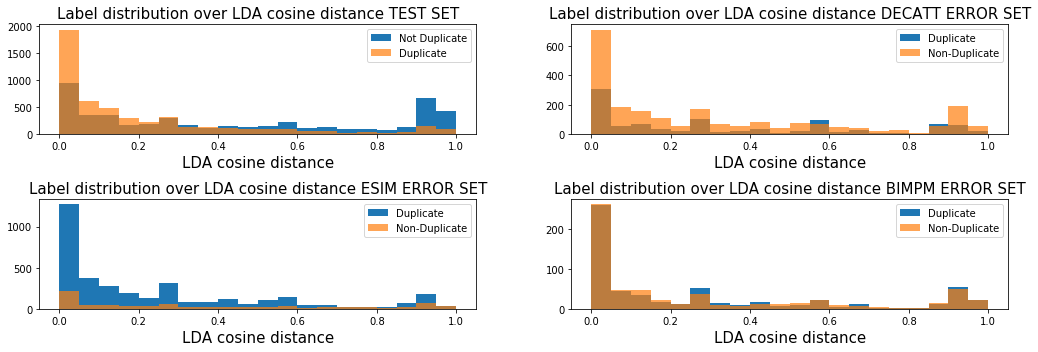

In [111]:
plt.figure(figsize=(15, 5))
plt.subplot(221)
plt.hist(df_test['lda_cos_dist'].loc[df_test['is_duplicate'] == 0], range=[0,1], bins=20, label='Not Duplicate')
plt.hist(df_test['lda_cos_dist'].loc[df_test['is_duplicate'] == 1], range=[0,1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over LDA cosine distance TEST SET', fontsize=15)
plt.xlabel('LDA cosine distance', fontsize=15)

plt.subplot(222)
plt.hist(df_decatt['lda_cos_dist'].loc[df_decatt['truth'] == 1], range=[0,1], bins=20, label='Duplicate')
plt.hist(df_decatt['lda_cos_dist'].loc[df_decatt['truth'] == 0], range=[0,1], bins=20, alpha=0.7, label='Non-Duplicate')
plt.legend()
plt.title('Label distribution over LDA cosine distance DECATT ERROR SET', fontsize=15)
plt.xlabel('LDA cosine distance', fontsize=15)

plt.subplot(223)
plt.hist(df_esim['lda_cos_dist'].loc[df_esim['truth'] == 1], range=[0,1], bins=20, label='Duplicate')
plt.hist(df_esim['lda_cos_dist'].loc[df_esim['truth'] == 0], range=[0,1], bins=20, alpha=0.7, label='Non-Duplicate')
plt.legend()
plt.title('Label distribution over LDA cosine distance ESIM ERROR SET', fontsize=15)
plt.xlabel('LDA cosine distance', fontsize=15)

plt.subplot(224)
plt.hist(df_bimpm['lda_cos_dist'].loc[df_bimpm['truth'] == 1], range=[0,1], bins=20, label='Duplicate')
plt.hist(df_bimpm['lda_cos_dist'].loc[df_bimpm['truth'] == 0], range=[0,1], bins=20, alpha=0.7, label='Non-Duplicate')
plt.legend()
plt.title('Label distribution over LDA cosine distance BIMPM ERROR SET', fontsize=15)
plt.xlabel('LDA cosine distance', fontsize=15)

plt.tight_layout()
plt.show()

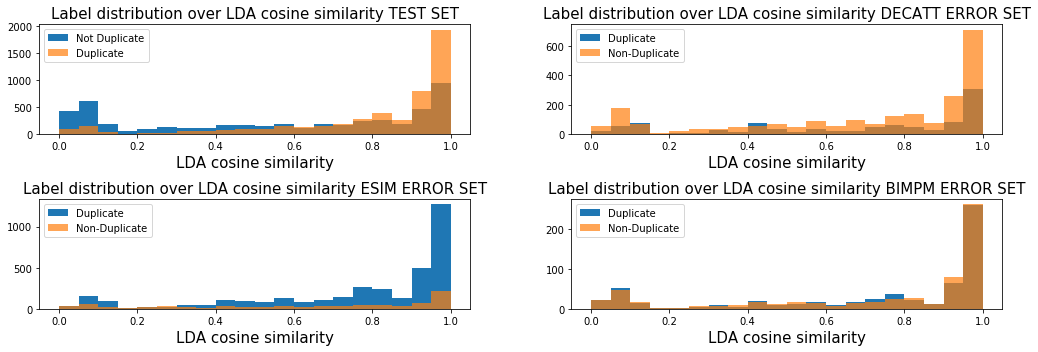

In [110]:
plt.figure(figsize=(15, 5))
plt.subplot(221)
plt.hist(df_test['lda_cos_sim'].loc[df_test['is_duplicate'] == 0], range=[0,1], bins=20, label='Not Duplicate')
plt.hist(df_test['lda_cos_sim'].loc[df_test['is_duplicate'] == 1], range=[0,1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over LDA cosine similarity TEST SET', fontsize=15)
plt.xlabel('LDA cosine similarity', fontsize=15)

plt.subplot(222)
plt.hist(df_decatt['lda_cos_sim'].loc[df_decatt['truth'] == 1], range=[0,1], bins=20, label='Duplicate')
plt.hist(df_decatt['lda_cos_sim'].loc[df_decatt['truth'] == 0], range=[0,1], bins=20, alpha=0.7, label='Non-Duplicate')
plt.legend()
plt.title('Label distribution over LDA cosine similarity DECATT ERROR SET', fontsize=15)
plt.xlabel('LDA cosine similarity', fontsize=15)

plt.subplot(223)
plt.hist(df_esim['lda_cos_sim'].loc[df_esim['truth'] == 1], range=[0,1], bins=20, label='Duplicate')
plt.hist(df_esim['lda_cos_sim'].loc[df_esim['truth'] == 0], range=[0,1], bins=20, alpha=0.7, label='Non-Duplicate')
plt.legend()
plt.title('Label distribution over LDA cosine similarity ESIM ERROR SET', fontsize=15)
plt.xlabel('LDA cosine similarity', fontsize=15)

plt.subplot(224)
plt.hist(df_bimpm['lda_cos_sim'].loc[df_bimpm['truth'] == 1], range=[0,1], bins=20, label='Duplicate')
plt.hist(df_bimpm['lda_cos_sim'].loc[df_bimpm['truth'] == 0], range=[0,1], bins=20, alpha=0.7, label='Non-Duplicate')
plt.legend()
plt.title('Label distribution over LDA cosine similarity BIMPM ERROR SET', fontsize=15)
plt.xlabel('LDA cosine similarity', fontsize=15)

plt.tight_layout()
plt.show()

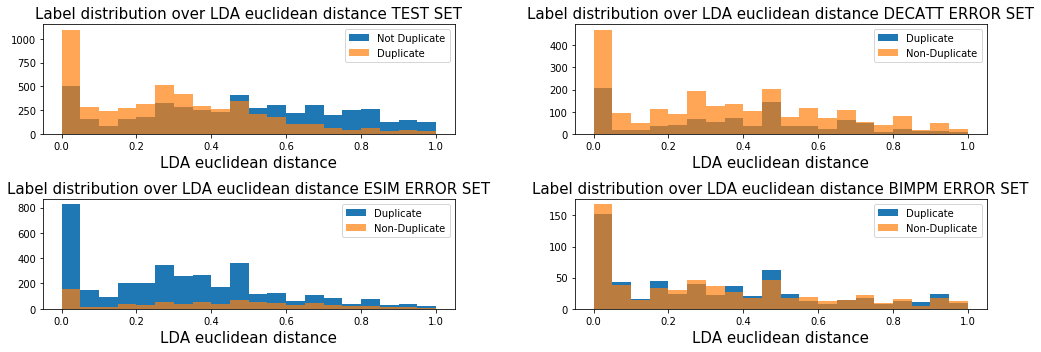

In [112]:
plt.figure(figsize=(15, 5))
plt.subplot(221)
plt.hist(df_test['lda_eucl_dist'].loc[df_test['is_duplicate'] == 0], range=[0,1], bins=20, label='Not Duplicate')
plt.hist(df_test['lda_eucl_dist'].loc[df_test['is_duplicate'] == 1], range=[0,1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over LDA euclidean distance TEST SET', fontsize=15)
plt.xlabel('LDA euclidean distance', fontsize=15)

plt.subplot(222)
plt.hist(df_decatt['lda_eucl_dist'].loc[df_decatt['truth'] == 1], range=[0,1], bins=20, label='Duplicate')
plt.hist(df_decatt['lda_eucl_dist'].loc[df_decatt['truth'] == 0], range=[0,1], bins=20, alpha=0.7, label='Non-Duplicate')
plt.legend()
plt.title('Label distribution over LDA euclidean distance DECATT ERROR SET', fontsize=15)
plt.xlabel('LDA euclidean distance', fontsize=15)

plt.subplot(223)
plt.hist(df_esim['lda_eucl_dist'].loc[df_esim['truth'] == 1], range=[0,1], bins=20, label='Duplicate')
plt.hist(df_esim['lda_eucl_dist'].loc[df_esim['truth'] == 0], range=[0,1], bins=20, alpha=0.7, label='Non-Duplicate')
plt.legend()
plt.title('Label distribution over LDA euclidean distance ESIM ERROR SET', fontsize=15)
plt.xlabel('LDA euclidean distance', fontsize=15)

plt.subplot(224)
plt.hist(df_bimpm['lda_eucl_dist'].loc[df_bimpm['truth'] == 1], range=[0,1], bins=20, label='Duplicate')
plt.hist(df_bimpm['lda_eucl_dist'].loc[df_bimpm['truth'] == 0], range=[0,1], bins=20, alpha=0.7, label='Non-Duplicate')
plt.legend()
plt.title('Label distribution over LDA euclidean distance BIMPM ERROR SET', fontsize=15)
plt.xlabel('LDA euclidean distance', fontsize=15)

plt.tight_layout()
plt.show()

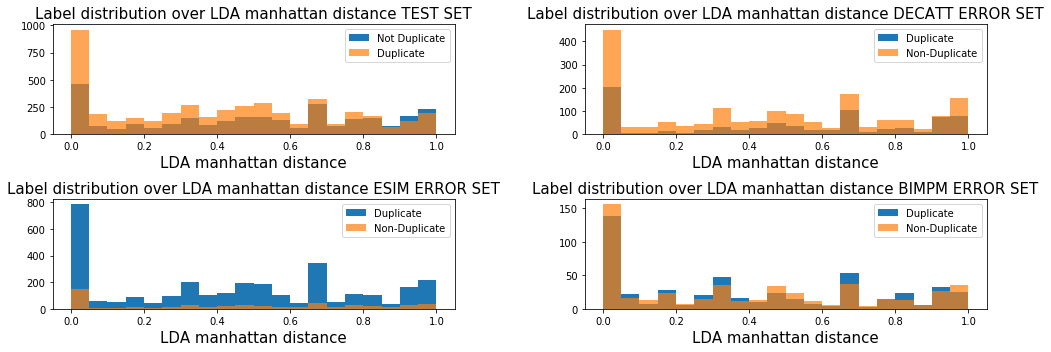

In [113]:
plt.figure(figsize=(15, 5))
plt.subplot(221)
plt.hist(df_test['lda_manh_dist'].loc[df_test['is_duplicate'] == 0], range=[0,1], bins=20, label='Not Duplicate')
plt.hist(df_test['lda_manh_dist'].loc[df_test['is_duplicate'] == 1], range=[0,1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over LDA manhattan distance TEST SET', fontsize=15)
plt.xlabel('LDA manhattan distance', fontsize=15)

plt.subplot(222)
plt.hist(df_decatt['lda_manh_dist'].loc[df_decatt['truth'] == 1], range=[0,1], bins=20, label='Duplicate')
plt.hist(df_decatt['lda_manh_dist'].loc[df_decatt['truth'] == 0], range=[0,1], bins=20, alpha=0.7, label='Non-Duplicate')
plt.legend()
plt.title('Label distribution over LDA manhattan distance DECATT ERROR SET', fontsize=15)
plt.xlabel('LDA manhattan distance', fontsize=15)

plt.subplot(223)
plt.hist(df_esim['lda_manh_dist'].loc[df_esim['truth'] == 1], range=[0,1], bins=20, label='Duplicate')
plt.hist(df_esim['lda_manh_dist'].loc[df_esim['truth'] == 0], range=[0,1], bins=20, alpha=0.7, label='Non-Duplicate')
plt.legend()
plt.title('Label distribution over LDA manhattan distance ESIM ERROR SET', fontsize=15)
plt.xlabel('LDA manhattan distance', fontsize=15)

plt.subplot(224)
plt.hist(df_bimpm['lda_manh_dist'].loc[df_bimpm['truth'] == 1], range=[0,1], bins=20, label='Duplicate')
plt.hist(df_bimpm['lda_manh_dist'].loc[df_bimpm['truth'] == 0], range=[0,1], bins=20, alpha=0.7, label='Non-Duplicate')
plt.legend()
plt.title('Label distribution over LDA manhattan distance BIMPM ERROR SET', fontsize=15)
plt.xlabel('LDA manhattan distance', fontsize=15)

plt.tight_layout()
plt.show()

# FuzzyWuzzy String Matching

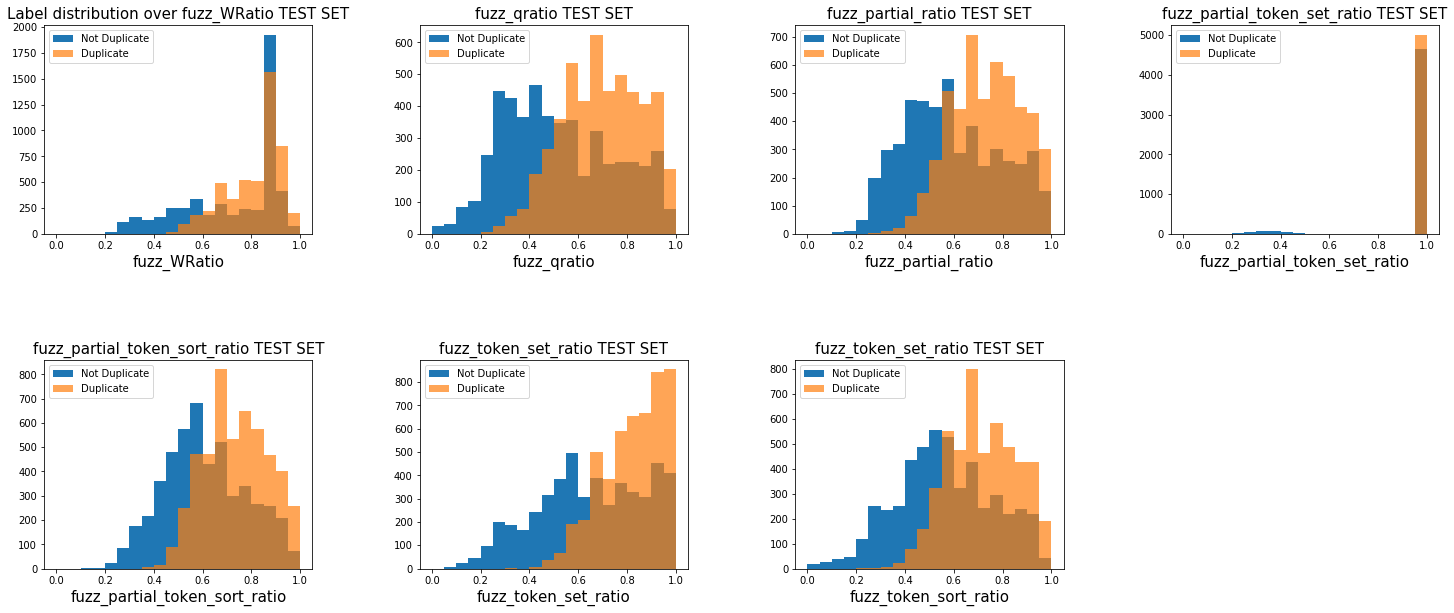

In [154]:
plt.figure(figsize=(25, 10))
plt.subplots_adjust(hspace=0.6, wspace=0.4)

plt.subplot(241)
plt.hist(df_test['fuzz_WRatio'].loc[df_test['is_duplicate'] == 0], range=[0,1], bins=20, label='Not Duplicate')
plt.hist(df_test['fuzz_WRatio'].loc[df_test['is_duplicate'] == 1], range=[0,1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over fuzz_WRatio TEST SET', fontsize=15)
plt.xlabel('fuzz_WRatio', fontsize=15)

plt.subplot(242)
plt.hist(df_test['fuzz_qratio'].loc[df_test['is_duplicate'] == 0], range=[0,1], bins=20, label='Not Duplicate')
plt.hist(df_test['fuzz_qratio'].loc[df_test['is_duplicate'] == 1], range=[0,1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('fuzz_qratio TEST SET', fontsize=15)
plt.xlabel('fuzz_qratio', fontsize=15)

plt.subplot(243)
plt.hist(df_test['fuzz_partial_ratio'].loc[df_test['is_duplicate'] == 0], range=[0,1], bins=20, label='Not Duplicate')
plt.hist(df_test['fuzz_partial_ratio'].loc[df_test['is_duplicate'] == 1], range=[0,1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('fuzz_partial_ratio TEST SET', fontsize=15)
plt.xlabel('fuzz_partial_ratio', fontsize=15)

plt.subplot(244)
plt.hist(df_test['fuzz_partial_token_set_ratio'].loc[df_test['is_duplicate'] == 0], range=[0,1], bins=20, label='Not Duplicate')
plt.hist(df_test['fuzz_partial_token_set_ratio'].loc[df_test['is_duplicate'] == 1], range=[0,1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('fuzz_partial_token_set_ratio TEST SET', fontsize=15)
plt.xlabel('fuzz_partial_token_set_ratio', fontsize=15)

plt.subplot(245)
plt.hist(df_test['fuzz_partial_token_sort_ratio'].loc[df_test['is_duplicate'] == 0], range=[0,1], bins=20, label='Not Duplicate')
plt.hist(df_test['fuzz_partial_token_sort_ratio'].loc[df_test['is_duplicate'] == 1], range=[0,1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('fuzz_partial_token_sort_ratio TEST SET', fontsize=15)
plt.xlabel('fuzz_partial_token_sort_ratio', fontsize=15)

plt.subplot(246)
plt.hist(df_test['fuzz_token_set_ratio'].loc[df_test['is_duplicate'] == 0], range=[0,1], bins=20, label='Not Duplicate')
plt.hist(df_test['fuzz_token_set_ratio'].loc[df_test['is_duplicate'] == 1], range=[0,1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('fuzz_token_set_ratio TEST SET', fontsize=15)
plt.xlabel('fuzz_token_set_ratio', fontsize=15)

plt.subplot(247)
plt.hist(df_test['fuzz_token_sort_ratio'].loc[df_test['is_duplicate'] == 0], range=[0,1], bins=20, label='Not Duplicate')
plt.hist(df_test['fuzz_token_sort_ratio'].loc[df_test['is_duplicate'] == 1], range=[0,1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('fuzz_token_set_ratio TEST SET', fontsize=15)
plt.xlabel('fuzz_token_sort_ratio', fontsize=15)

# plt.tight_layout()
plt.show()